<a href="https://colab.research.google.com/github/emmanuellaanggi/PantunGen-GPT/blob/main/%F0%9F%A9%B0_Pantun_Generator_with_GPT_2_%F0%9F%A9%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Getting Started**

Before running the code, it is easier that you make shortcut of [This Drive](https://drive.google.com/drive/folders/11Ci0FGnOV7yVyNHVotgovRkujM8C0sir?usp=sharing) to your Google Drive home 😁

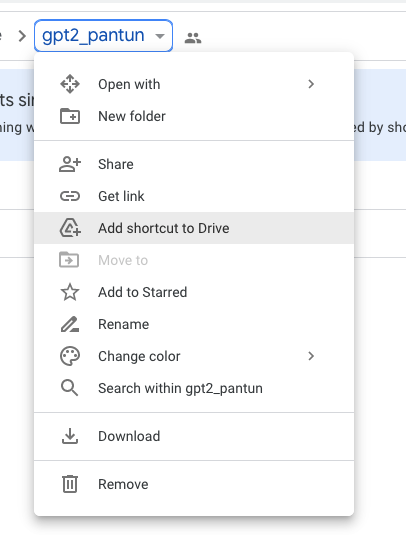

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Preprocess** 🚁

In this phase, there will be simple preprocessing to get additional token to GPT-2 model.

In [3]:
# Call the dataset from Drive source
import pandas as pd

dff = pd.read_csv("/content/drive/MyDrive/gpt2_pantun/pantun_corpus.csv")
df = pd.DataFrame({"pantun": dff["teks"]})

df1 = df.pantun.str.split("\n",expand=True)
df_token = pd.DataFrame({"pantun": df.pantun, "pantun_token":""})

In [4]:
# Add token to identify each structure of the Pantun
df_token["pantun_token"] = "<MULAI> " + df1[0] + " <JEDA> " + df1[1] + "<JEDA> <ISI> " + df1[2] + " <JEDA> " + df1[3] + " <JEDA> <SELESAI>"
df_token = df_token[df_token['pantun_token'].notna()]
data = df_token["pantun_token"]

In [5]:
## Split the dataset into Train and Test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(data.values, test_size=0.1, random_state=31) 

In [6]:
import re
print('Len train: ', len(train))
print('Len test: ', len(test))

##Put the dataset into .txt file to ease the Tokenizer process
with open('train.txt', 'w+') as f:
    for text in train:
      teks = text.split()[::-1]
      teks = str(" ".join(teks))
      teks = teks.replace("-", " ")
      teks = re.sub(' +', ' ', teks)
      f.write(repr(teks) +' \n' )
        
with open('test.txt', 'w+') as f:
    for text in test:
      teks = text.split()[::-1]
      teks = str(" ".join(teks))
      teks = teks.replace("-", " ")
      teks = re.sub(' +', ' ', teks)
      f.write(repr(teks) +' \n' )

Len train:  12117
Len test:  1347


#**GPT-2 FINETUNE** 🦾

## **Fine-tuning Traning** ⛽️

This process took [Hugging Face' Legacy Example](https://github.com/huggingface/transformers/blob/main/examples/legacy/run_language_modeling.py) for Fine-tuning their pre-trained model.

In [7]:
# Install Transformer Library
!pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 33.8 MB/s 
     |████████████████████████████████| 880 kB 41.1 MB/s 
     |████████████████████████████████| 3.0 MB 40.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=868fde19001a590618fafafa546ee0f2041587b5be3bd2658da72fb1076303d1
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [8]:
# Import Transformer Package to the environment
import transformers

Use the file stored in GDrive to train the model

In [9]:
# Use the file stored in GDrive for Fine-tuning training from dataset collected
!python /content/drive/MyDrive/gpt2_pantun/run.py \
--output_dir='gpt2-pantun' \
--model_type=gpt2 \
--model_name_or_path='cahya/gpt2-small-indonesian-522M' \
--do_train \
--train_data_file='train.txt' \
--do_eval \
--eval_data_file='test.txt' \
--per_device_train_batch_size=24 \
--per_device_eval_batch_size=24 \
--line_by_line \
--evaluate_during_training \
--learning_rate 8e-05 \
--num_train_epochs=10

Streaming output truncated to the last 5000 lines.
Iteration:  87% 441/505 [01:38<00:14,  4.45it/s]
Iteration:  88% 442/505 [01:38<00:14,  4.47it/s]
Iteration:  88% 443/505 [01:38<00:13,  4.54it/s]
Iteration:  88% 444/505 [01:38<00:13,  4.55it/s]
Iteration:  88% 445/505 [01:39<00:13,  4.50it/s]
Iteration:  88% 446/505 [01:39<00:12,  4.57it/s]
Iteration:  89% 447/505 [01:39<00:12,  4.61it/s]
Iteration:  89% 448/505 [01:39<00:12,  4.64it/s]
Iteration:  89% 449/505 [01:39<00:12,  4.66it/s]
Iteration:  89% 450/505 [01:40<00:11,  4.65it/s]
Iteration:  89% 451/505 [01:40<00:11,  4.60it/s]
Iteration:  90% 452/505 [01:40<00:11,  4.52it/s]
Iteration:  90% 453/505 [01:40<00:11,  4.58it/s]
Iteration:  90% 454/505 [01:41<00:11,  4.51it/s]
Iteration:  90% 455/505 [01:41<00:10,  4.59it/s]
Iteration:  90% 456/505 [01:41<00:10,  4.63it/s]
Iteration:  90% 457/505 [01:41<00:10,  4.59it/s]
Iteration:  91% 458/505 [01:41<00:10,  4.65it/s]
Iteration:  91% 459/505 [01:42<00:10,  4.59it/s]
Iteration:  91% 46

# **Generate Free-form Pantun** 🏜

In [2]:
import sys
import argparse
import logging

import numpy as np
import torch

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer)

In [3]:
MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop
MODEL_CLASSES = {
    "gpt2": (GPT2LMHeadModel, GPT2Tokenizer),
}
repetition_penalty = 1.0


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

        
def adjust_length_to_model(length, max_sequence_length):
    if length < 0 and max_sequence_length > 0:
        length = max_sequence_length
    elif 0 < max_sequence_length < length:
        length = max_sequence_length  # No generation bigger than model size
    elif length < 0:
        length = MAX_LENGTH  # avoid infinite loop
    return length

In [4]:
model_type = "gpt2"
model_name_or_path = '/content/gpt2-pantun'
temperature=1.0
k=50
p=0.9
seed = 42
no_cuda = "store_true"
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
n_gpu = 0 if no_cuda else torch.cuda.device_count()
length = 100
set_seed(seed)
model_class, tokenizer_class = MODEL_CLASSES[model_type]
tokenizer = tokenizer_class.from_pretrained(model_name_or_path)
model = model_class.from_pretrained(model_name_or_path)
model.to(device)
length = adjust_length_to_model(length, max_sequence_length=model.config.max_position_embeddings)

In [12]:
prompt_input = "<SELESAI>"
prompt_text = prompt_input #' '.join(reversed(prompt_input.split(' ')))
stop_token = "<MULAI>"
gens = []

In [15]:
  for i in range(100):
    num_return_sequences = 1
    encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=True, return_tensors="pt")
    encoded_prompt = encoded_prompt.to(device)

    if encoded_prompt.size()[-1] == 0:
      input_ids = None
    else:
      input_ids = encoded_prompt


    output_sequences = model.generate(
            input_ids=input_ids,
            max_length=length + len(encoded_prompt[0]),
            temperature=temperature,
            top_k=k,
            top_p=p,
            repetition_penalty=repetition_penalty,
            do_sample=True,
            num_return_sequences=num_return_sequences,
            pad_token_id=tokenizer.eos_token_id
        )
    if len(output_sequences.shape) > 2:
      output_sequences.squeeze_()

    generated_sequences = []

    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
      generated_sequence = generated_sequence.tolist()
      
      # Decode text
      text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
      
      # Remove all text after the stop token
      text = text[: text.find(stop_token) if stop_token else None]
      
      # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
      total_sequence = (
                text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]
            )
      
    i = stop_token + ' '.join(reversed(total_sequence.split(' ')))
    print(i)
    gens.append(i)

<MULAI> minum air perasan <JEDA> kalau lewat penjual jamu <JEDA> <ISI> aku lagi kedengeran <JEDA> tapi ingatingatlah temanmu <JEDA> <SELESAI> 
<MULAI> jarum emas di dalam peti <JEDA> hilang satu di taman melati <JEDA> <ISI> kekasih harus berbagi <JEDA> dalam hidupmu selama ini. <JEDA> <SELESAI> 
<MULAI> siapa suka duduk mengaji <JEDA> banyaklah ilmu dapat dikenang <JEDA> <ISI> siapa suka mengelokkan budi <JEDA> ke hilir ke hulu disayangi orang <JEDA> <SELESAI> 
<MULAI> subuh hari mengambil nangka <JEDA> setelah bekerja seharian <JEDA> <ISI> anak rindu akan pulang <JEDA> dapat istri orang <JEDA> <SELESAI> 
<MULAI> bersama paman naik kuda <JEDA> untuk membeli seekor sapi <JEDA> <ISI> saat malam kamu sendirian <JEDA> jangan pulang saat sore hari <JEDA> <SELESAI> 
<MULAI> anak gembala pandai bersulap <JEDA> sulap dimainkan di tengah hari <JEDA> <ISI> salam penutup tak terjawab <JEDA> kuulangi sekali lagi <JEDA> <SELESAI> 
<MULAI> turuncoba mencari tempayan <JEDA> pergi kepasar membawa roti